<a href="https://colab.research.google.com/github/ankit-kothari/Data-Science-Journey/blob/transformers_lp_course/sentiment_analysis_lp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
import transformers 
import  matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np 
import pandas as pd 
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,roc_auc_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Datasets

In [7]:
raw_datasets = load_dataset("glue","sst2")


Reusing dataset glue (/root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [9]:
print(raw_datasets['train'])
print(dir(raw_datasets['train']))

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 67349
})
['_TF_DATASET_REFS', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_build_local_temp_path', '_check_index_is_initialized', '_data', '_fingerprint', '_format_columns', '_format_kwargs', '_format_type', '_get_cache_file_path', '_get_output_signature', '_getitem', '_indexes', '_indices', '_info', '_iter', '_map_single', '_new_dataset_with_indices', '_output_all_columns', '_push_parquet_shards_to_hub', '_split', 'add_column', 'add_elasticsearch_index', 'add_faiss_index', 'add_faiss_index_from_external_arrays', 'add_item', 'align_labels_with_mapping

In [10]:
type(raw_datasets['train'])

datasets.arrow_dataset.Dataset

In [11]:
raw_datasets['train'].data

MemoryMappedTable
sentence: string
label: int64
idx: int32
----
sentence: [["hide new secretions from the parental units ","contains no wit , only labored gags ","that loves its characters and communicates something rather beautiful about human nature ","remains utterly satisfied to remain the same throughout ","on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ","that 's far too tragic to merit such superficial treatment ","demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ","of saucy ","a depressed fifteen-year-old 's suicidal poetry ","are more deeply thought through than in most ` right-thinking ' films ",...,"sealed with a kiss ","very ugly ","why this project was undertaken ","the mill sci-fi film with a flimsy ending and ","halfhearted ","dilutes the pleasure of watching them ","the emotion is impressively true for being so hot-blooded , and ","can get your m

In [12]:
raw_datasets['train'][0]

{'idx': 0,
 'label': 0,
 'sentence': 'hide new secretions from the parental units '}

In [13]:
raw_datasets['train'][50000:50003]

{'idx': [50000, 50001, 50002],
 'label': [1, 1, 1],
 'sentence': ['glow ',
  'a classical dramatic animated feature ',
  'best espionage picture ']}

In [14]:
raw_datasets['train'].features

{'idx': Value(dtype='int32', id=None),
 'label': ClassLabel(num_classes=2, names=['negative', 'positive'], id=None),
 'sentence': Value(dtype='string', id=None)}

In [15]:
len(raw_datasets['train'])

67349

In [16]:
raw_datasets['train'].column_names

['sentence', 'label', 'idx']

In [17]:
raw_datasets['train']['sentence'][:5]

['hide new secretions from the parental units ',
 'contains no wit , only labored gags ',
 'that loves its characters and communicates something rather beautiful about human nature ',
 'remains utterly satisfied to remain the same throughout ',
 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ']

##From Datasets to DataFrame


In [18]:
raw_datasets.set_format(type='pandas')
tweet_data = raw_datasets['train'][:]

In [19]:

int2str_label = raw_datasets['train'].features['label'].names
int2str_mapping = {k:v for k,v in enumerate(int2str_label)}
int2str_mapping

{0: 'negative', 1: 'positive'}

In [20]:
%%timeit
tweet_data['label_name']= tweet_data['label'].map(int2str_mapping)

The slowest run took 4.44 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 1.79 ms per loop


In [21]:
tweet_data.head()

,sentence,label,idx,label_name
0,hide new secretions from the parental units,0,0,negative
1,"contains no wit , only labored gags",0,1,negative
2,that loves its characters and communicates som...,1,2,positive
3,remains utterly satisfied to remain the same t...,0,3,negative
4,on the worst revenge-of-the-nerds clichés the ...,0,4,negative


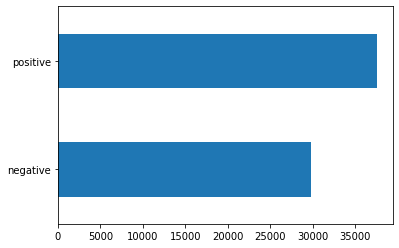

In [22]:
tweet_data['label_name'].value_counts(ascending=True).plot.barh()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


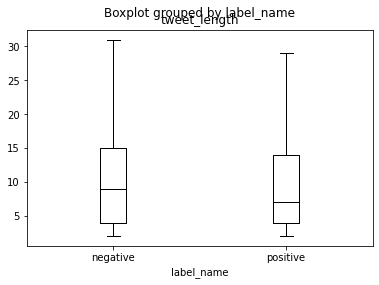

In [23]:
tweet_data['tweet_length']= tweet_data['sentence'].apply(lambda x: len(x.split(' ')))
tweet_data.boxplot("tweet_length", by="label_name", color="black",grid=False, showfliers=False)

In [24]:
tweet_data.groupby(['label_name'])['tweet_length'].describe()

,count,mean,std,min,25%,50%,75%,max
label_name,,,,,,,,
negative,29780.0,10.882874,8.157512,2.0,4.0,9.0,15.0,53.0
positive,37569.0,10.034363,7.987037,2.0,4.0,7.0,14.0,53.0


In [25]:
raw_datasets.reset_format()

## From Text to Tokenization


In [26]:
from transformers import AutoTokenizer

In [27]:
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

### Text Tokens to Integer Ids

In [28]:
tokenized_sentences = tokenizer(raw_datasets['train'][0:3]['sentence'])
pprint(tokenized_sentences)

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'input_ids': [[101, 5342, 2047, 3595, 8496, 2013, 1996, 18643, 3197, 102],
               [101,
                3397,
                2053,
                15966,
                1010,
                2069,
                4450,
                2098,
                18201,
                2015,
                102],
               [101,
                2008,
                7459,
                2049,
                3494,
                1998,
                10639,
                2015,
                2242,
                2738,
                3376,
                2055,
                2529,
                3267,
                102]]}


### Integer Ids to Tokens

In [29]:
back2tokens = tokenizer.convert_ids_to_tokens(tokenized_sentences['input_ids'][0])
back2tokens

['[CLS]',
 'hide',
 'new',
 'secret',
 '##ions',
 'from',
 'the',
 'parental',
 'units',
 '[SEP]']

In [30]:
print(tokenizer.convert_tokens_to_string(back2tokens))

[CLS] hide new secretions from the parental units [SEP]


### Tokenization the entire dataset

In [31]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True,padding=True)

tokenized_dataset = raw_datasets.map(tokenize_fn, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-c6e71d05afb55ca6.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-429c3afbc7935684.arrow


In [32]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 1821
    })
})

In [33]:
pprint(tokenize_fn(raw_datasets['train'][:3]))

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'input_ids': [[101,
                5342,
                2047,
                3595,
                8496,
                2013,
                1996,
                18643,
                3197,
                102,
                0,
                0,
                0,
                0,
                0],
               [101,
                3397,
                2053,
                15966,
                1010,
                2069,
                4450,
                2098,
                18201,
                2015,
                102,
                0,
                0,
                0,
                0],
               [101,
                2008,
                7459,
                2049,
                3494,
                1998,
                10639,
          

###Transfer Learing
- Getting the pre_trained model
- extract the last hidden state features 
- with a new head train the features on a classification model 


In [34]:
from transformers import AutoModel
import torch

In [35]:
model_ckpt =  'distilbert-base-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
text = "this is a test"
inputs = tokenizer(text, return_tensors='pt') #returning pytorch tensor 

In [38]:
inputs['input_ids'].size()

torch.Size([1, 6])

In [39]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [40]:
inputs ={k:v.to(device) for k,v in inputs.items()}

In [41]:
inputs

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1]]),
 'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]])}

In [42]:
with torch.no_grad():
  outputs = model(**inputs)

In [43]:
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [44]:
def extract_hidden_states(batch):
  #place the model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  #Extract the last hidden state
  last_hidden_state = model(**inputs).last_hidden_state
  #Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].detach().numpy()}

In [45]:
tokenized_dataset.set_format('torch',columns=['input_ids','attention_mask','label'])

In [46]:
tokenized_dataset.shape

{'test': (1821, 5), 'train': (67349, 5), 'validation': (872, 5)}

In [47]:
type(tokenized_dataset)

datasets.dataset_dict.DatasetDict

In [48]:
tokenized_dataset['train'][0:2000].keys()

dict_keys(['label', 'input_ids', 'attention_mask'])

In [49]:
tweet_data_hidden = tokenized_dataset.map(extract_hidden_states, batched=True, batch_size=200)

  0%|          | 0/337 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [51]:
X_train = np.array(tweet_data_hidden['train']["hidden_state"])
y_train = np.array(tweet_data_hidden['train']["label"])
X_valid = np.array(tweet_data_hidden['validation']["hidden_state"])
y_valid = np.array(tweet_data_hidden['validation']["label"])

In [52]:

model = RandomForestClassifier(bootstrap=True,min_samples_split=5,class_weight={0: 1, 1: 5})
model.fit(X_train,y_train)


RandomForestClassifier(class_weight={0: 1, 1: 5}, min_samples_split=5)

In [53]:
preds = model.predict(X_valid)

In [59]:
cm = confusion_matrix(y_valid, preds, labels=[0, 1])

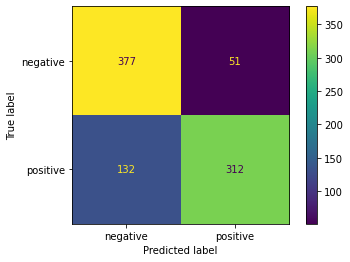

In [62]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['negative', 'positive'])
disp.plot()
plt.grid(False)
plt.show()

In [63]:
print(classification_report(y_valid,preds))

              precision    recall  f1-score   support

           0       0.74      0.88      0.80       428
           1       0.86      0.70      0.77       444

    accuracy                           0.79       872
   macro avg       0.80      0.79      0.79       872
weighted avg       0.80      0.79      0.79       872

